# Introduction au Deep Learning

Auteur : Jérémie Jakubowicz

Date : 26/01/2017

La première partie de ce tutoriel suit [cette page](https://www.tensorflow.org/tutorials/mnist/beginners/)

## La notion de neurone artificiel (ou perceptron)

**Avertissement** : la notion de neurone que nous présentons n'est pas la plus générale possible. Elle ne permet pas, par exemple, de représenter les neurones d'un réseau de type `Boltzmann`. Elle est néanmoins suffisamment générale pour représenter un grand nombre de réseaux de neurones couramment utilisés ; dont les réseaux de type `perceptrons multicouches` et `autoencodeurs`. Son attrait pour cet exposé vient du bon compromis simplicité/généricité qu'elle permet.

Un *neurone artificiel* désigne une fonction $x\in\mathbb{R}^m\mapsto f(w\cdot x + b)$ où $w\in\mathbb{R}^m$ est un vecteurs dont les composantes sont appellées les *poids* du neurone et $b\in\mathbb{R}$ est un scalaire appelé le *biais* du neurone. La fonction $f:\mathbb{R}\to\mathbb{R}$ est, elle, appellée *fonction d'activation* du neurone. On représente souvent le neurone de la façon suivante :

<img src='figures/neurone_artificiel.png' alt='neurone artificel' height=512 width=512></img>

**Remarque :** L'origine de cette dénomination est connectiviste et cherche à modéliser le fonctionnement d'un neurone du vivant. Un neurone du monde vivant s'active ou non en fonction d'un potentiel synaptique. Néanmoins, dans le détail, le fonctionnement d'un neurone artificiel est très différent d'un neurone du monde vivant qui s'active par *spikes* et qui encode son activité de façon beaucoup plus complexe qu'un "simple" scalaire de sortie.

Néanmoins, une cette analogie avec le monde vivant explique pourquoi une fonction qui émule un comportement "on/off" tout en étant plus lisse, est intéressante dans ce contexte. Une fonction couramment utilisée est la fonction `sigmoïde`
$$\sigma:s\mapsto\frac{1}{1+\exp-s}$$
dont on représente le graphe à la cellule suivante.

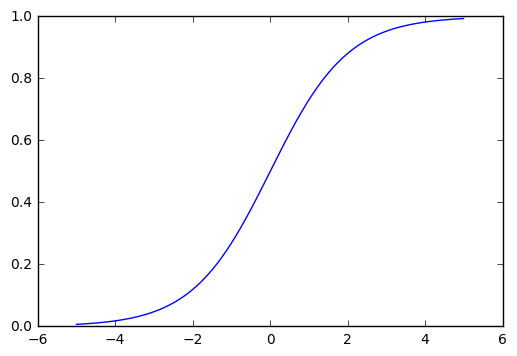

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
s = np.arange(-5,5,0.01)
plt.plot(s, 1./(1+np.exp(-s)))

# Le code suivant aligne les sorties sous forme d'images
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Lorsqu'on a n données $(x_i, y_i)$ où $x_i\in\mathbb{R}^m$ et $y_i\in\{0,1\}$ présente un comportement binaire, on peut chercher à *apprendre* les poids du neurone, c'est-à-dire à minimiser une perte de la forme:
$$\sum_{i=1}^n l(f(w\cdot x_i +b), y_i)$$

Quand on cherche à résoudre le problème précédent avec $f=\sigma$, la fonction sigmoïde et $l(y,y') = -y'\log y$, *i.e.* la fonction $\log$-`loss`, on pose en réalité le même problème qu'une regression logistique.

## Premiers pas à l'aide de `tensorflow`

Dans le workshop de Machine Learning on a beaucoup utilisé la librairie `scikit-learn`. Bien que cette librairie, qui nous a permis d'apprendre des modèles linéaires généralisés, des fôrets d'arbres aléatoires, des arbres boostés, permette aussi d'estimer les paramètres d'un perceptron, ses possibilités sont, à date, limitées en ce qui concerne l'apprentissage des réseaux de neurones. Autant donc se familiariser avec une librairie puissante dans le domaine de l'apprentissage des réseaux de neurones, et en particulier des réseaux de neurones profonds. Plusieurs librairies se distinguent à date : `theano`, `torch` et `tensorflow`. D'autres librairies existent également. Nous nous focaliserons dans cet atelier sur la librairie `tensorflow` qui présente l'avantage d'être bien interfaçable avec python, puissante et bien documentée.

On va donc faire nos premiers pas pour estimer les paramètres d'un perceptron à l'aide de `tensorflow`. Le cas d'usage que nous utiliserons est en quelque sorte le "hello world" du deep learning, il s'agit de la reconnaissance de chiffres dans des imagettes digitales. Nous utiliserons la base d'imagettes dite `MNIST` (Mixed National Institute of Standards and Technology database) qui est accessible depuis `tensorflow`.

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


On voit que la variable `mnist` est composée de trois bases :

In [8]:
print(type(mnist.train))
for x in [mnist.train, mnist.validation, mnist.test]:
    print(x.num_examples)

<class 'tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet'>
55000
5000
10000


Chacune de ces bases contient à la fois les imagettes et les labels :

In [4]:
mnist.train.images.shape

(55000, 784)

In [5]:
mnist.train.labels.shape

(55000, 10)

Chaque imagette est formée de 28x28 pixels (784 pixels) qui sont empilés dans un vecteur ligne de taille 784. Comme il y a $55\, 000$ imagette dans la base `mnist.train`, le vecteur `mnist.train.images` a une taille `(55000,784)`. Chaque label correspond au chiffre entre 0 et 9 que représente l'imagette. L'encodage `one-hot` est appliqué qui donne donc un vecteur ligne de taille `10`.

Une extension multiclass de la fonction $\log$-loss s'écrit:
$$l(y,y') = -\sum_{j=1}^p y'_j\log y_j$$
On l'appelle `entropie croisée`.

Ici, on va entraîner 10 perceptrons linéaires, chacun dédié à un des 10 chiffres, qui donneront chacun $s_j = w_j\cdot x + b_j$ et on va en déduire $y_j$ par softmax, *i.e.*:
$$y_j = \frac{\exp s_j}{\sum_{j'=1}^{J}\exp s_{j'}}$$
On retrouve donc le modèle logistique quand $J=2$, sauf qu'ici $J=10$.
On écrit de manière concise:
$$
y = \mathrm{softmax}(s)
$$

On regroupant les dix poids $w_j$ dans une unique matrice $W$ de taille $10\times784$ et tous les $b_j$ dans un vecteur de taille $10\times 1$ on réécrit:
$$ y =\mathrm{softmax}(W\cdot x + b) $$
où $x$ désigne un vecteur de taille $1\times 784$ tel que le sont les imagettes.

Pour apprendre les poids $W$ et $b$ grâce à tensorflow, il faut d'abord apprendre un peu de syntaxe tensorflowesque. En particulier pour définir la fonction $x\mapsto\mathrm{softmax}(W\cdot x + b)$, on commence par définir $x$ comme une variable muette, un `placeholder` selon la terminologie `tensorflow` et $W$ et $b$ comme des variables.

In [6]:
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

Pour `x`, on prête attention au `None` qui deviendra en fait non pas `1` mais la taille de la base à traiter (55000 dans le cas de `mnist.train`)

Puis on définit le modèle à proprement parler:

In [7]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

In [8]:
y

<tf.Tensor 'Softmax:0' shape=(?, 10) dtype=float32>

Le problème d'optimisation qu'on va chercher à résoudre grâce à `tensorflow` s'écrit:
$$\inf_{W,b} R_n(W,b) = \sum_{i=1}^n\mathrm{crossentropy}(\mathrm{softmax}(W\cdot x_i+b),y_i)$$

Il faut donc définir $\mathrm{crossentropy}$ en `tensorflow`:

In [9]:
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

On estimera alors $W$ et $b$ par une *descente de gradient*:
$$W_{t+1} = W_t - \gamma \nabla_W R_n(W_t,b_t)$$
$$b_{t+1} = b_t - \gamma \nabla_b R_n(W_t,b_t)$$
En `tensorflow` on décrit les iterations par:

In [10]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

Il faut alors initialiser $W_0$ et $b_0$ ainsi qu'itérer ces étapes de descente de gradient un nombre prédéfini de fois:

In [11]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
for i in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

On va alors évaluer la *précision* des paramètres appris, on choisissant la classe prédite comme celle dont le $y_j$ est le plus élevé:
$$\frac1n\sum_{i=1}^n 1\{\mathrm{argmax}(W\cdot x_i +b) = \mathrm{argmax}(y_i)\}$$

In [12]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9171


Soit un peu moins de $8\%$ d'erreurs, ce qui prouve que nos $10$ neurones ne répondent pas n'importe quoi. Par contre, comme on peut s'en douter avec un modèle aussi simple, on est loin des performances de [l'état-de-l'art](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

Il est instructif de représenter les poids $W$. Or chacune des composantes de chaque $w_j$ formant $W$ est multipliée par un pixel de l'image $x$ donné. On peut donc représenter les $w_j$ comme des images.

In [13]:
Wnd = sess.run(W.value())

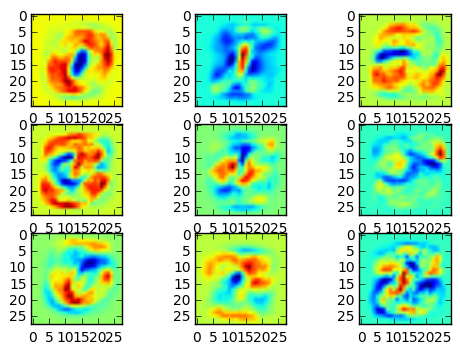

In [14]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(Wnd[:,i].reshape([28,28]))

## Perceptron Multi-Couches

Dans la partie précédente, on a utilisé sans le dire, non pas un neurone mais une *couche de neurones*. En effet, on a précisé qu'on utilisait un neurone par chiffre. Quand on représente ces neurones, on obtient ce schéma :

<img src='figures/single-layer-perceptron-network.png' alt='neurone artificel' height=384 width=384></img>

Formellement, la différence n'est pas flagrante :
$$y = f^{\otimes J}(W\cdot x + b)$$

Le point intéressant, c'est que lorsqu'on dispose de cette notion de couche de neurones, on peut empiler les couches, c'est-à-dire composer les fonctions. On obtient alors un schéma qui ressemble au suivant :

<img src='figures/multilayer-perceptrons.png' alt='neurone artificel' height=384 width=384></img>

Il assez naturel de voir comment `tensorflow` permet d'apprendre les paramètres d'un tel réseau.

Ce qui suit provient de [cette page](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/multilayer_perceptron.py)

In [15]:
# Parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100
display_step = 1

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess1:
    sess1.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess1.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Optimization Finished!")

    correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess1.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Epoch: 0001 cost= 179.826162345
Epoch: 0002 cost= 40.353936456
Epoch: 0003 cost= 24.998076785
Epoch: 0004 cost= 17.506988875
Epoch: 0005 cost= 12.446736570
Epoch: 0006 cost= 9.236861153
Epoch: 0007 cost= 7.108253222
Epoch: 0008 cost= 5.270819859
Epoch: 0009 cost= 3.958663956
Epoch: 0010 cost= 3.054218576
Epoch: 0011 cost= 2.237660584
Epoch: 0012 cost= 1.752751776
Epoch: 0013 cost= 1.347809892
Epoch: 0014 cost= 1.103918589
Epoch: 0015 cost= 0.881122994
Optimization Finished!
0.9424


C'est mieux, mais on est encore loin de l'état-de-l'art. On pourrait augmenter le nombre de couches cachées (exercice!) pour voir si on arrive à de bonnes performances mais on risque d'être déçu...

On en tire notre première leçon : si on admet (et il suffit de regarder le [benchmark](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)) que c'est le Deep Learning qui donne les meilleurs résultats sur MNIST ; alors le Deep Learning ne se résume pas à entraîner un perceptron multicouches.

## Réseaux de Neurones Convolutifs

Ce qui suit provient de [cette page](https://www.tensorflow.org/tutorials/mnist/pros/)

Comme on va utiliser les fonctions d'activations ReLU, on va devoir initialiser les poids de façon légérement positive (pour éviter les gradients nuls)

In [16]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

Et voici les fonctions clefs de cette section

In [18]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

### Première couche (convolution)

On va utiliser des patchs de taille $5\times 5$ et on va extraire $32$ features de chacun de ces patches

In [19]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

On transforme les images (qui sont des vecteurs 1d aplatis) en tenseurs 3d dont la 3eme dimension est triviale parce que les images sont en niveaux de gris.

In [20]:
x_image = tf.reshape(x, [-1,28,28,1])

In [21]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

La sortie de cette couche est donc de taille 28x28x32 (à cause du 0-padding), sinon elle serait de taille (24x24x32)

### Deuxième couche (max-pooling)

In [22]:
h_pool1 = max_pool_2x2(h_conv1)

La sortie de cette couche est de taille 14x14x32

### Troisième couche (2ème convolution)

In [23]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

### Quatrième couche (2ème max-pooling)

In [24]:
h_pool2 = max_pool_2x2(h_conv2)

A ce stade la sortie est de taille 7x7x64

### Cinquième couche (totalement connectée)

In [25]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Dropout pour l'entraînement

In [26]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Couche de sortie (softmax)

In [27]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [26]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.06
step 100, training accuracy 0.9
step 200, training accuracy 0.88
step 300, training accuracy 0.96
step 400, training accuracy 0.96
step 500, training accuracy 0.9
step 600, training accuracy 0.96
step 700, training accuracy 0.96
step 800, training accuracy 0.96
step 900, training accuracy 0.94
step 1000, training accuracy 0.94
step 1100, training accuracy 0.94
step 1200, training accuracy 0.98
step 1300, training accuracy 1
step 1400, training accuracy 1
step 1500, training accuracy 1
step 1600, training accuracy 0.96
step 1700, training accuracy 1
step 1800, training accuracy 0.98
step 1900, training accuracy 0.98
step 2000, training accuracy 0.98
step 2100, training accuracy 0.98
step 2200, training accuracy 0.98
step 2300, training accuracy 0.98
step 2400, training accuracy 0.96
step 2500, training accuracy 0.98
step 2600, training accuracy 1
step 2700, training accuracy 1
step 2800, training accuracy 0.96
step 2900, training accuracy 0.96
step 3000, t

On n'est toujours pas au niveau des performances "état-de-l'art" mais on s'en rappoche sérieusement. Pour donner un ordre d'idées, personne n'obtenait de telles performances avant 1998, date où cette approche a prouvé son efficacité pour ce problème. Les progrès qui ont été fait depuis ne changent pas fondamentalement l'approche.

En ce qui nous concerne, ça sera la fin de l'histoire pour ce qui touche aux images. On passe aux lettres !

## Méthodes neuronales pour l'analyse de textes

Avec les images et l'audio, c'est le troisième type de données pour lesquelles le deep-learning "cartonne". En réalité, on va le voir, il y a plusieurs méthodes pour utiliser les réseaux de neurones sur du texte. On commence par une des plus populaires du moment : word2vec

### word2vec

Ce qui suit est tiré de [cette page](https://www.tensorflow.org/tutorials/word2vec/)

L'idée de base est que le réseau de neurones va essayer de comprendre le texte par de la prédiction. La philosophie derrière, discutable, est la suivante : si j'arrive à prédire le prochain mot en fonction de ce qui précède, c'est que j'ai bien compris le texte. En terme de réseau de neurones, il s'agit de trouver la configuration et les poids de la couche cachée de l'architecture suivante.

<img src='figures/predict_next_word.png' alt='neurone artificel' height=512 width=512></img>

Toutefois, c'est un programme utopique. En effet, $V$ désigne la taille du vocabulaire et est souvent de l'ordre de $10^4$, voire $10^4$. Une première astuce va être utilisée

<img src='figures/noise-classifier.png' alt='neurone artificel' height=512 width=512></img>

On commence à s'approcher de la méthode implémentée. Plutôt que d'expliquer les différences conceptuelles, on va commencer par décrire précisément en quoi consiste cette méthode.

In [30]:
vocabulary_size = 50000
embedding_size = 200

In [32]:
import math
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                      stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

A partir de maintenant, on suppose que chaque mot est représenté par un entier unique. Les données consistent donc en une liste d'entiers (un texte).

In [33]:
# Placeholders for inputs
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

On transforme ensuite ces entiers en vecteurs grâce à la fonction :

In [34]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

On peut alors calculer l'estimation par contraste au bruit

In [36]:
num_sampled = 10
# Compute the NCE loss, using a sample of the negative labels each time.
loss = tf.reduce_mean(
  tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                 num_sampled, vocabulary_size))

Puis on en déduit le problème d'optimisation

In [37]:
# We use the SGD optimizer.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)

Et on est prêt à apprendre sur un corpus de texte